In [8]:
#imports
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
bm = Basemap()

from matplotlib.gridspec import GridSpec
from scipy import stats
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


In [9]:
print('begin')
path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/Summer_Months/full_physics_essentials_valid_month02_targets.nc"
ds = xr.open_dataset(path_to_file)
truths = ds.targets[:, -1].values
#truths = ds.targets.values
lons = ds.lon.values
lats = ds.lat.values

x = 144
y = 96
z = 30
t = int(len(truths)/(x*y))
print(t)

print('halfway')
path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Models/3_Months_Summer_Maybe_Old_ReLU.nc"

ds = xr.open_dataset(path_to_file)
truths = ds.Prediction[:, -1].values
#SPERPA_DNN = np.squeeze(ds.Prediction.values)

begin
8831
halfway


In [10]:
SPCAM5_Truth = np.zeros(shape=(t, y, x))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = truths[count]
            SPCAM5_Truth[i, j, k] = A
            count = count + 1

In [11]:
lats = lats[::144][:96]
lons = lons[:144]

In [12]:
ny = 96
nx = lons.size
nday = int(t/96)
nperday = 96


#Make an empty array of 0's by days, samples in a day, at each lat/lon coord
SPCAM5_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))

#loop over the number of days
count = 0
for i in range(len(SPCAM5_data_reorganized)):
    #loop over the samples per day
    for j in range(len(SPCAM5_data_reorganized[0])):
        SPCAM5_data_reorganized[i, j, :, :] = np.squeeze(SPCAM5_Truth[count , :, :])
        #CAM_data_reorganized[i, j, :, :] = np.squeeze(CAM_Data[count , :, :])
        count = count+1

In [13]:
SPCAM5_themean = np.nanmean(SPCAM5_data_reorganized, axis = 0)
SPCAM5_thestd = np.nanstd(SPCAM5_data_reorganized, axis = 0)

In [14]:
SPCAM5_amplitude_map = np.zeros(shape=(ny, nx))
SPCAM5_phase_map_utc = np.zeros(shape=(ny, nx))
SPCAM5_phase_map_lst = np.zeros(shape=(ny, nx))

In [15]:
dataset = netCDF4.Dataset("/fast/gmooers/Preprocessed_Data/PRECT_JJA_rcat.nc")

t = np.array(dataset.variables['time'])
utc_hour = (t[:96] - math.floor(t[0]))*24.0-0.125
utc_hour[0] = utc_hour[0]+24

In [16]:
#loop through longitudes
for i in range(len(SPCAM5_data_reorganized[0][0][0])):
    lst_hour = utc_hour +(lons[i]/360.)*24.
    lst_hour[lst_hour > 24] = lst_hour[lst_hour > 24] - 24
    
    #loop through latitudes
    for j in range(len(SPCAM5_data_reorganized[0][0])):
        SPCAM5_precip_cycle = np.squeeze(SPCAM5_themean[:, j, i])
        SPCAM5_amplitude_here = max(SPCAM5_precip_cycle)-min(SPCAM5_precip_cycle)
        SPCAM5_stderr_here = np.squeeze(max(SPCAM5_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        
        if SPCAM5_amplitude_here >= 2.0*SPCAM5_stderr_here:
            SPCAM5_amplitude_map[j, i] = SPCAM5_amplitude_here
            if np.std(SPCAM5_precip_cycle) > 0.0:
                index_max = np.argmax(SPCAM5_precip_cycle)
                SPCAM5_phase_map_utc[j, i] = utc_hour[index_max]
                SPCAM5_phase_map_lst[j, i] = lst_hour[index_max]

#generate apropriate lat/lon map
Xvar, Yvar = np.meshgrid(lons, lats)

In [17]:
SPCAM5_nan_map_utc = SPCAM5_phase_map_utc 
SPCAM5_nan_map_lst = SPCAM5_phase_map_lst
for i in range(len(SPCAM5_phase_map_utc)):
    for j in range(len(SPCAM5_phase_map_utc[i])):
        if SPCAM5_phase_map_utc[i][j] == 0.0:
            SPCAM5_nan_map_utc[i][j] = np.nan
            SPCAM5_nan_map_lst[i][j] = np.nan

In [18]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

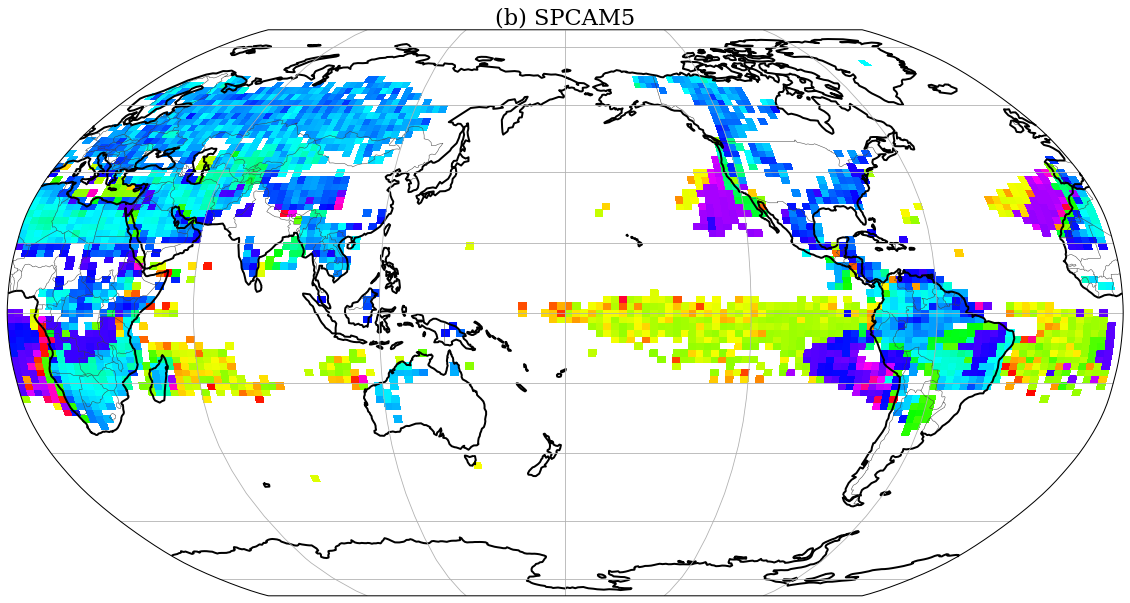

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(20,13)

contour_plot = ax.pcolormesh(Xvar, Yvar, SPCAM5_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
ax.set_title('(b) SPCAM5', fontsize = fz)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

In [20]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/LST_PRECIP_Trial_ReLU.npy", SHERPA_nan_map_lst)

NameError: name 'SHERPA_nan_map_lst' is not defined